<a href="https://colab.research.google.com/github/SammyBrimberry/GoogleBigQuery_attritionClassification/blob/main/gbq_attrition_classificationV1_AP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [139]:
import pandas as pd
import numpy as np
import io
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE


import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from collections import Counter

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from sklearn.metrics import confusion_matrix

from imblearn.metrics import classification_report_imbalanced
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import ClusterCentroids

from sklearn.decomposition import PCA

from sklearn.metrics import precision_score
from sklearn.metrics import recall_score



In [15]:
# access data locally 
from google.colab import files
uploaded = files.upload()
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))



Saving data.csv to data (1).csv


In [174]:
df =df.replace({'Attrition': {'Yes': True, 'No': False}}) ## do this to match cloud version of data


In [16]:
# # account authentication
# from google.colab import auth
# auth.authenticate_user()
# print('Authenticated') # check

In [17]:
# # import biqguery, this is where our csv is living
# from google.cloud import bigquery

# # view settings
# %load_ext google.colab.data_table

In [18]:
# store project_id into object
# project_id = 'civil-hope-323521'

In [19]:
# init gbq client for specific cloud project
# client = bigquery.Client(project=project_id)

In [20]:
# # query our entire data living in google cloud
# df = client.query('''
# select * 
# from `civil-hope-323521.attrition_dataset_1.IBM_attrition_2021` # project_id.database.table
# ''').to_dataframe()

# df.head() # print out first 5 rows

The first step in understanding this data set is to understand the number of employees that have left the company. To do so, we can group the employees by attrition status and count the number of employees that fall into each category. Those numbers can be visualized in the bar graph below. 

Already, we can see that our data is imbalanced. A challenge for classification is to pay attention to balance and imbalance data, which will be explained shortly. 

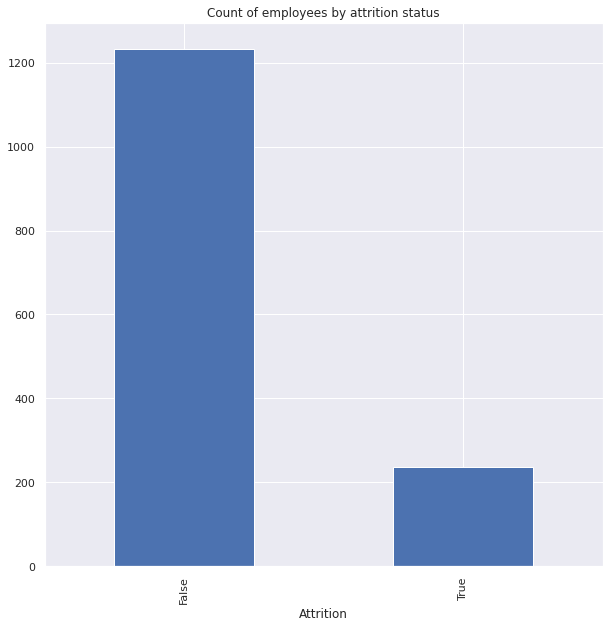

In [176]:
# count number of attrition
df1 = df.groupby(by='Attrition').size() #this creates a new dataframe that groups the employees by attrition status and then provides a count for the number in each group
#.reset_index(name='counts')
#plot the counts
df1.plot(kind='bar',title = "Count of employees by attrition status", figsize=(10,10))


Not all the variables in the dataset will be useful to build a model that explains attrition. That being said, we want to start breaking down the data to understand if any particular set of features seem to be the key in explaining the variation in attrition. We can start by taking educated gueesses as to which features are most closely aligned with attrition.



We may start by looking at the average number of firms the employees of each of the two groups have been employed at over a period of time. To do so, we can group the data by attrition status and find the average number of past employmnets for each group. The graph below depicts the results. 


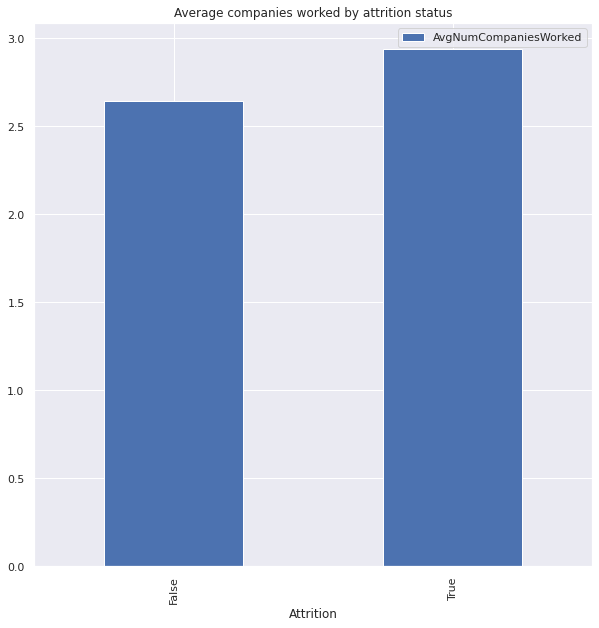

In [177]:
# roles by attrition status
df2 = df[["Attrition", "NumCompaniesWorked"]].rename(columns={"NumCompaniesWorked": "AvgNumCompaniesWorked"}).groupby(['Attrition']).mean() #group by attrition and take the mean of the number of companies employees worked on
#plot results
df2.plot(kind='bar',title = "Average companies worked by attrition status", figsize=(10,10))

	

From this bar graph it may be difficult to discern if the variation in number of past employments is related to the variation in attrition. While the avaergae number of past employments is higher for those that left, it is unclear how significant this difference is. Plotting the distribution will better explain the difference in variation. 

In [178]:
# px.scatter(df[["Attrition", "NumCompaniesWorked"]], x='NumCompaniesWorked', y="NumCompaniesWorked", size=1, color='Attrition')
# fg = seaborn.FacetGrid(data=df[["Attrition", "NumCompaniesWorked"]], hue='Attrition', aspect=1.61)
# fg.map(plt.scatter, 'NumCompaniesWorked', 'NumCompaniesWorked').add_legend()


In [179]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,True,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,False,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,True,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,False,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,False,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


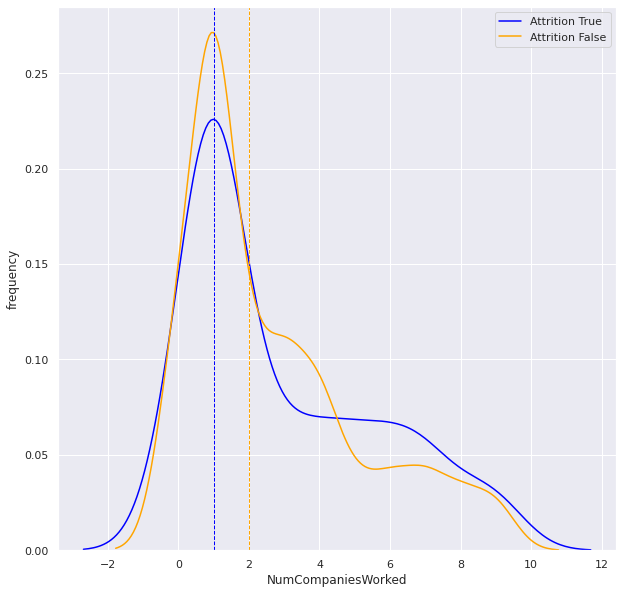

In [180]:
dfplot = df[["Attrition", "NumCompaniesWorked"]]
attrition_t = dfplot[dfplot["Attrition"]== True] #dataframe of attrition=True
attrition_f = dfplot[dfplot["Attrition"]== False] #dataframe of attrition=False

# attrition_t = dfplot[dfplot["Attrition"]== "Yes"] #dataframe of attrition=True
# attrition_f = dfplot[dfplot["Attrition"]== "No"] #dataframe of attrition=False

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(10,10)})
sns.distplot(attrition_t["NumCompaniesWorked"], color="blue", hist=False, label="Attrition True") #Hitogram of attrition false
sns.distplot(attrition_f["NumCompaniesWorked"], color="orange", hist=False, label="Attrition False") #histogram of attirtion true 
# plt.figure(figsize = (10,10))
plt.axvline(attrition_t["NumCompaniesWorked"].median(), color="blue", linestyle="dashed", linewidth=1) #plot median of attrition true
plt.axvline(attrition_f["NumCompaniesWorked"].median(), color="orange", linestyle="dashed", linewidth=1) #plot median of attrition false 

plt.ylabel("frequency") #plot label
plt.legend() #add label

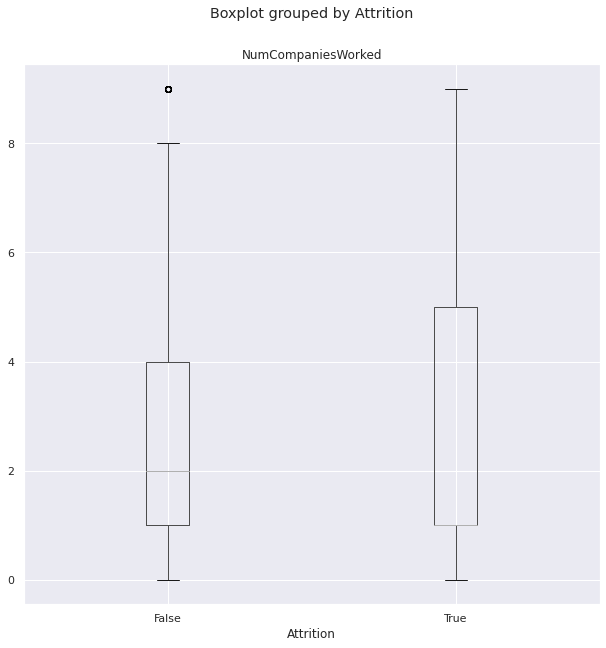

In [181]:
#plot a boxplot to visualize the distribution in number of companies worked at for each group
df.boxplot("NumCompaniesWorked", "Attrition", figsize=(10,10))

From the two graphs above, we can see that the distributions and medians are quite similar across both groups. This may suggest that number of companies worked may not really explain attrition. We can now do a similar visual analysis for other numerical features of interest. 

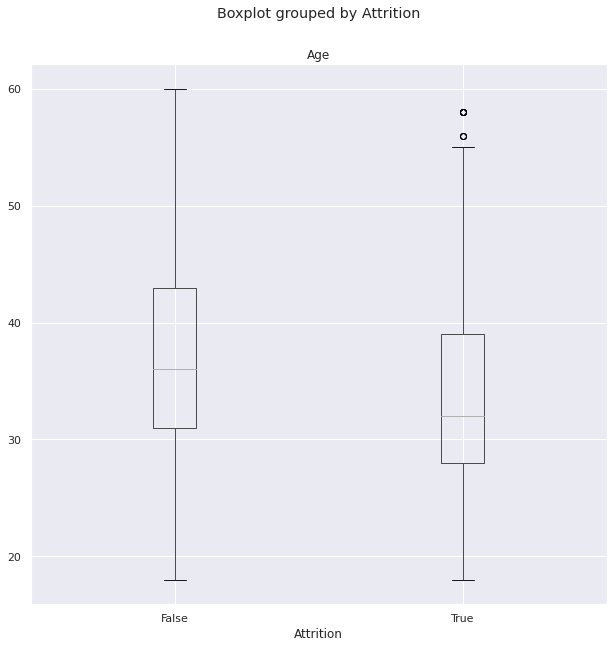

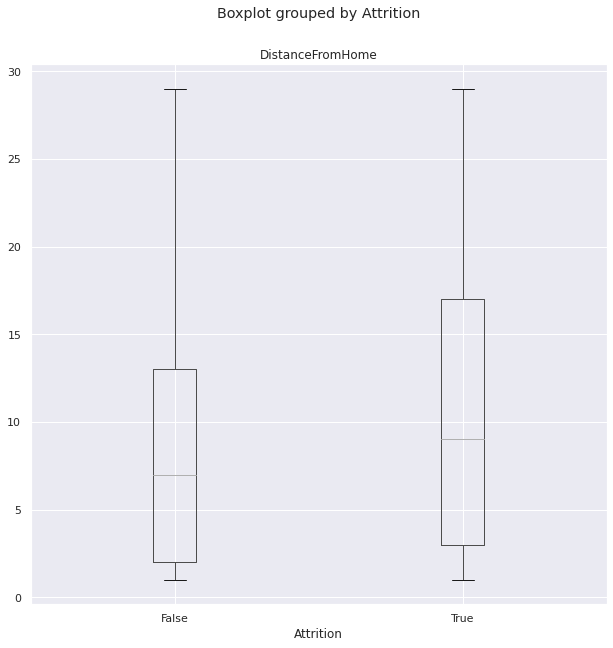

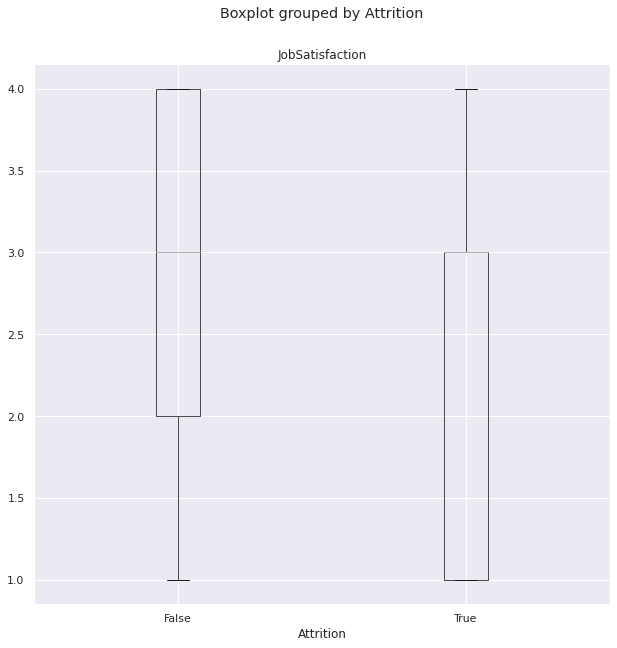

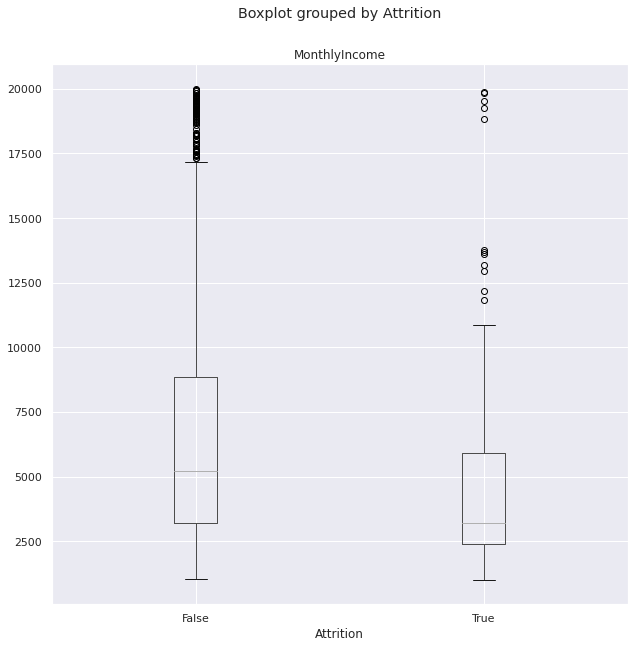

In [182]:
#plot other box plots
features = ["Age", "DistanceFromHome", "JobSatisfaction", "MonthlyIncome"]
for feature in features: #loop through the chosen features to produce boxplots
  df.boxplot(feature, "Attrition", figsize=(10,10))


A possible takeaway from these graphs are that younger people are more likely to leave their job. A greater DistanceFromHome, lower JobSatisfaction and lower MonthlyIncome may also influence attrition. 

A stacked Column chart will be more useful to visualize the relationship between two categorical variables (Some fo the categorical features and attrition). It visualizes the percentage that each category from one variable contributes to a total across categories of the second variable. --re word

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


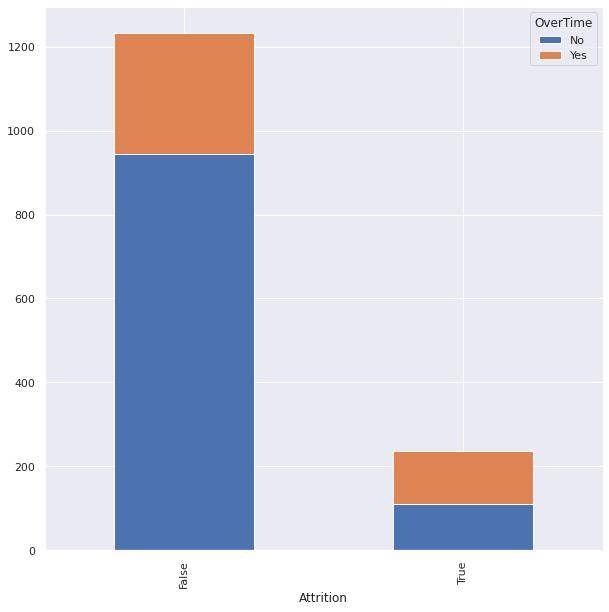

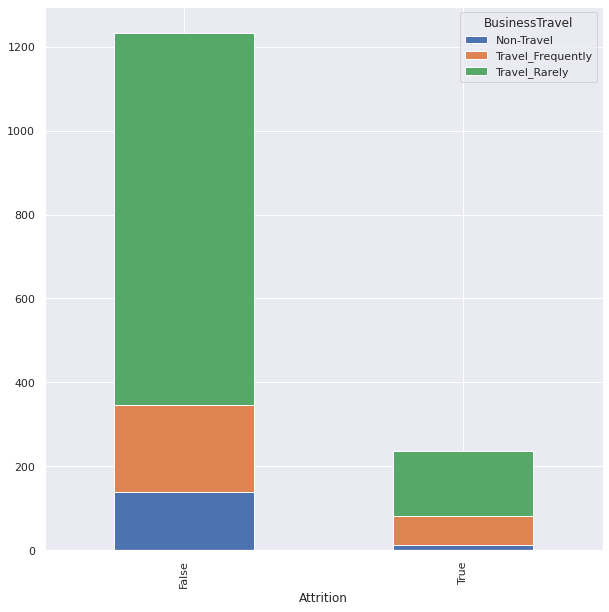

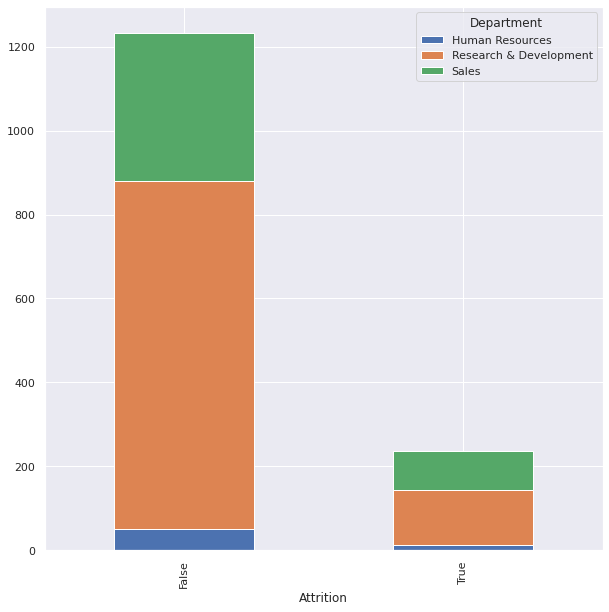

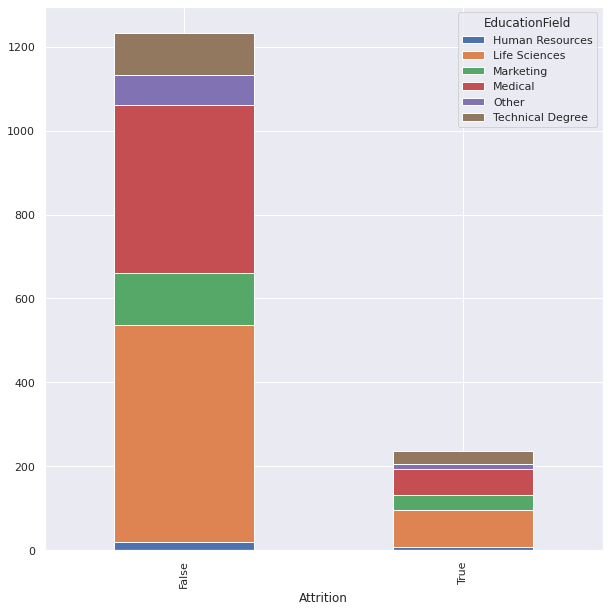

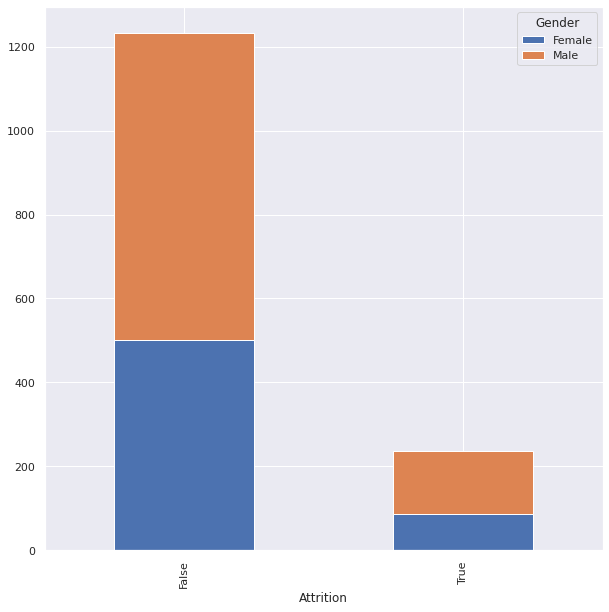

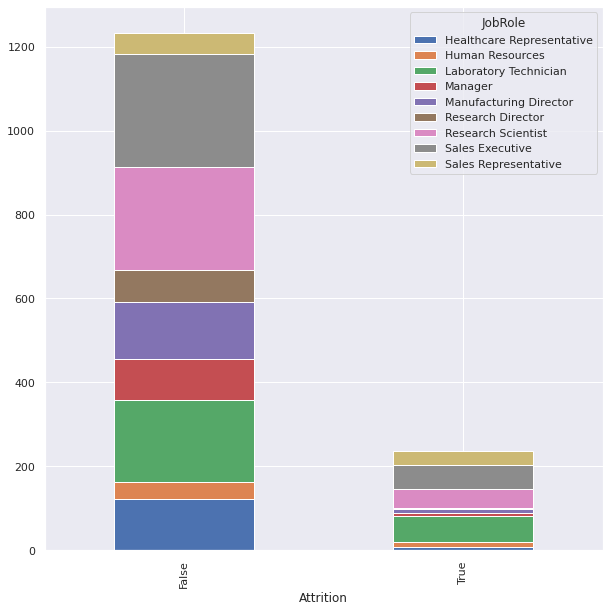

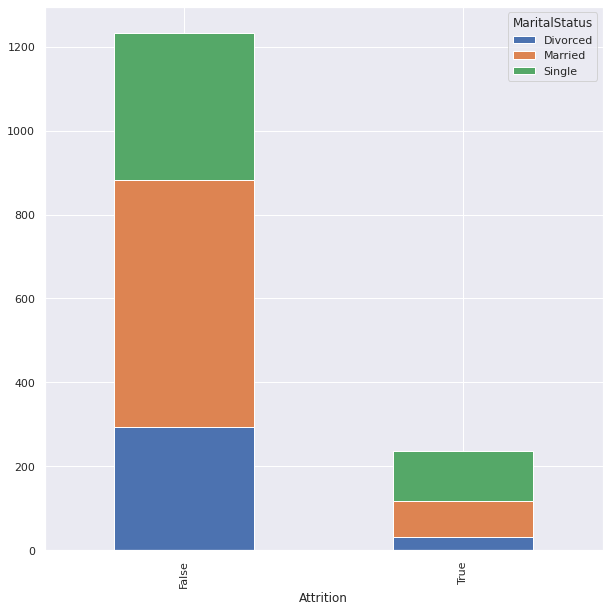

In [183]:
categories = ["OverTime", 'BusinessTravel', 'Department', 'EducationField', 'Gender', 'JobRole', 'MaritalStatus'] #list of categorical features to examine
for category in categories: #loop through each categorical feature 
  df_new = df.groupby(["Attrition", category])[category].count().unstack().plot(kind = "bar", stacked = True, figsize=(10,10)) #print stacked bar chart
  print(df_new)

From the graphs above, we can start seeing that the rate of overtime is much higher in the attrition group then the non attrition group. The rate of singles is much higher in attrition as well. Employees who travel often seem to be affected more often from attrition. From these grpahs, it looks like gender is not related to Attrition. 

It is also important to note and discard the few features with absolutely no variation between attrition groups. "Over18", "EmployeeCount", and "StandardHours" have only one value, thus they will definitely not expalin any of the variation in atrition. 

EmployeeNumber can also be dropped for now, as it represents a unique identifier for each employee.





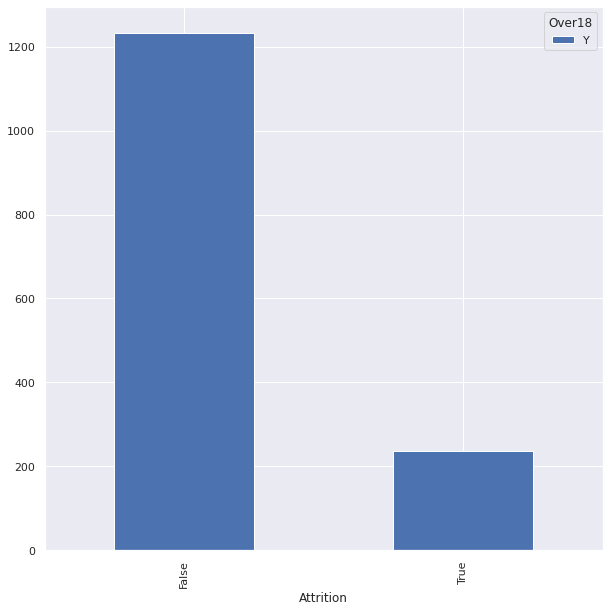

In [184]:
df_new = df.groupby(["Attrition", "Over18"])["Over18"].count().unstack().plot(kind = "bar", stacked = True) #show there is only one value in over18


In [185]:
#drop the columns that won't be relvent to prediction
df_drop = df.copy(deep=True)
df_drop.drop(columns = {"Over18", "EmployeeCount", "EmployeeNumber", "StandardHours"}, inplace = True)


In [186]:
df_drop.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,True,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Yes,11,3,1,0,8,0,1,6,4,0,5
1,49,False,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,No,23,4,4,1,10,3,3,10,7,1,7
2,37,True,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Yes,15,3,2,0,7,3,3,0,0,0,0
3,33,False,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Yes,11,3,3,0,8,3,3,8,7,3,0
4,27,False,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,No,12,3,4,1,6,3,3,2,2,2,2


In [187]:
df.head()


,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,True,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,False,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,True,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,False,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,False,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


#Logistic Regression - Basic Classification 

In [188]:
df_drop.columns

Index(['Age', 'Attrition', 'BusinessTravel', 'DailyRate', 'Department',
       'DistanceFromHome', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'HourlyRate', 'JobInvolvement',
       'JobLevel', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
       'MonthlyIncome', 'MonthlyRate', 'NumCompaniesWorked', 'OverTime',
       'PercentSalaryHike', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'TotalWorkingYears', 'TrainingTimesLastYear',
       'WorkLifeBalance', 'YearsAtCompany', 'YearsInCurrentRole',
       'YearsSinceLastPromotion', 'YearsWithCurrManager'],
      dtype='object')

The first step in a classification problem is to seperate categorical and numerical features. Typically this can be done by assuming all data with with "String" as its type is categorical and all data with integers as its type is numerical. However, in this case, some of the numerical data is really on a likert scale. (Data on a likert scale can either been seen as categorical or numerican due to the ordered nature of the categories). However, some of the numerical data are true categorical features with no intervall or true zero (Education etc.). In these cases, we can decide how to hand each feature. All categorical data needs to be dummy encoded (when only two categories exist) or one hot encoded (when multiple categories exist). 

In [189]:
# define features
df_copy = df_drop.copy(deep=True)


#X=df_copy.drop(columns=['Attrition"])
#X = pd.get_dummies(X)- this would work because it knos to only convert strings, but some of our categorical data is numeric

#if we dont treat likert as categorical, we can do this
numerical = df_copy.dtypes[df_copy.dtypes != "object"].index
categorical = df_copy.dtypes[df_copy.dtypes== "object"].index
# Cat = categorical.tolist()



In [190]:
#pull out the feature we decided were numerical
numerical = df_copy[["Age", "DailyRate", "DistanceFromHome","HourlyRate", "MonthlyIncome", 'MonthlyRate', 'NumCompaniesWorked',
        'PercentSalaryHike',
       'TotalWorkingYears', 'TrainingTimesLastYear', 
       'YearsAtCompany', 'YearsInCurrentRole', 'YearsSinceLastPromotion',
       'YearsWithCurrManager']]

#pull out the features we decided are categorical
categorical = df_copy[['BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'OverTime', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel','WorkLifeBalance']].astype(str)
categorical = pd.get_dummies(categorical, drop_first=True) #dropping a category within each feature is important to prevent multicolliniarity

X = categorical.merge(numerical, left_index=True, right_index=True)
X_copy = X.copy(deep=True)
X_copy_2 = X.copy(deep=True)


In [191]:
#another way to encode
df_encoded = pd.get_dummies(data = df_copy, columns = ["Attrition", 'BusinessTravel', 'Department', 'Education', 'EducationField', 'EnvironmentSatisfaction', 'Gender', 
       'JobInvolvement', 'JobLevel', 'JobRole', 'JobSatisfaction',
       'MaritalStatus', 'OverTime', 'PerformanceRating',
       'RelationshipSatisfaction', 'StockOptionLevel','WorkLifeBalance'], drop_first=True)

df_encoded.head()

,Age,DailyRate,DistanceFromHome,HourlyRate,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_True,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Research & Development,Department_Sales,Education_2,Education_3,Education_4,Education_5,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,EnvironmentSatisfaction_2,EnvironmentSatisfaction_3,EnvironmentSatisfaction_4,Gender_Male,JobInvolvement_2,JobInvolvement_3,JobInvolvement_4,JobLevel_2,JobLevel_3,JobLevel_4,JobLevel_5,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,JobSatisfaction_2,JobSatisfaction_3,JobSatisfaction_4,MaritalStatus_Married,MaritalStatus_Single,OverTime_Yes,PerformanceRating_4,RelationshipSatisfaction_2,RelationshipSatisfaction_3,RelationshipSatisfaction_4,StockOptionLevel_1,StockOptionLevel_2,StockOptionLevel_3,WorkLifeBalance_2,WorkLifeBalance_3,WorkLifeBalance_4
0,41,1102,1,94,5993,19479,8,11,8,0,6,4,0,5,1,0,1,0,1,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,1,0,0,0,0,0,0,0,0,0,0
1,49,279,8,61,5130,24907,1,23,10,3,10,7,1,7,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,1,0,0,0,1,0
2,37,1373,2,92,2090,2396,6,15,7,3,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,1,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,1,0
3,33,1392,3,56,2909,23159,1,11,8,3,8,7,3,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,0,0,1,0
4,27,591,2,40,3468,16632,9,12,6,3,2,2,2,2,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,1,0


In [192]:
# X.describe()

In [193]:

# set target
target = ['Attrition'] # we want to predict this value
y = df_copy.loc[:, target].copy()

y['Attrition'].value_counts() # same as count above

False    1233
True      237
Name: Attrition, dtype: int64

The next step is to implement the train-test split procedure. This is a mechanism used to estimate the performance of machine learning algorithms. The training data is used to build the algorithm and the testing data is used to measure the performance of the algorithm. It is important to set aside testing data, otherwise the model will be build around all your data and surely overfit it. 



In [194]:
#set aside some data fro training the model and some for testing 
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=41)

We will now fit a simple logistic regression 

In [195]:
model = LogisticRegression(solver='lbfgs',random_state=42)#setting up the regression
model.fit(X_train,y_train)#fitting the regression to the training data
target_predictions = model.predict(X_test)#using the model to make predictions on the testing data


In [117]:
# y_test["Predictions"] = target_predictions #Add the prediction array to the target test data 
# y_test.merge(X_test, left_index=True, right_index=True) #merge the actual target, predictions with the rest of the record for those employees
# #merging with X_test only gives you the dummy encoded data and none of the droped data -- you dont get the employee number
# #the order of the y_test, y predictions and x_test should all be the same -- which can be confirmed by the indices. 



In [118]:
# #now merge the predictions with the original data by matching the indecies -- the reccords that were not in the test (dont have prediction will be filled in with an NA)
# predictions = y_test.drop(['Attrition'], axis=1)
# result = df.merge(predictions, how='left', left_index=True, right_index=True)
# result.iloc[[663]]

In [119]:
# #create a dataframe with just the employee numbers (ID), real attrition status and predictions
# final_results = result[["EmployeeNumber","Attrition", "Predictions"]]

In [120]:
# final_results['accuracy'] = final_results['Predictions'] #set accuracy column equal to prediction
# #if prediction is null (ie was not in test), make accuracy null
# #if prediction matched attrition, set accuracy to 1
# #if prediction does not macth attrition, set accuracy to 0 
# final_results['accuracy'] = np.where(final_results['accuracy'].isnull(), final_results['accuracy'], (final_results['Attrition']==final_results['Predictions']).astype(int))


In [121]:
# #pull out a dataframe of all the correctly predicted employees to export
# employees_predicted_correctly = final_results[(final_results['accuracy'] == 1)] #find all the rows in the results df where the accuracy column equals 1 
# employees_predicted_correctly.to_csv('employees_predicted_correctly.csv', index=False)
# employees_predicted_correctly


In [122]:
# #pull out a dataframe of all the correctly predicted employees to export
# employees_predicted_incorrectly = final_results[(final_results['accuracy'] == 0)]
# employees_predicted_incorrectly.to_csv('employees_predicted_incorrectly.csv', index=False)
# employees_predicted_incorrectly

#Accuracy - Basic Logistic Regression

We now want to judge the accuracy of our model by comparing the predicted results with the test data we put aside. A balanced accuracy score takes into account the fact that our data is imbalanced (comtains much few datapoints where attrition is true)

In [196]:
balanced_accuracy_score(y_test, target_predictions) #function that 

0.5052830188679245

In [197]:
accuracy_score(y_test, target_predictions)

0.8586956521739131

We can see that the accuracy score is much higher (better) then the balanced score due to the large class imbalance. Accuracy is defined as the correct predictions/total number of data points. When there is a class imbalance, the model is likely overfitting. 

A confusion matrix is another way of visualizing the results of a classification problem. Because classification accuracy alone can be misleading if you have an unequal number of observations in each group, a confusion matrix can give you a better idea of what your classification model is getting right and what types of errors it is making. 


In [198]:
cm = confusion_matrix(y_test, target_predictions)
cm

array([[315,   3],
       [ 49,   1]])

In [199]:
tn = cm[0][0]
fp = cm[0][1]
fn = cm[1][0]
tp=cm[1][1]


The four quadrants of the confusion matrix are:
True negatives (attrition equals no and we predicted no), false positive (attrition equals no but we guessed yes), false negative (attrition equals yes, but we guessed no), and true positive (attrition is yes and we guessed yes). 


Using this breakdown of the prediction results, we can also use other metrics to better define the accuracy; Precision and *Recall*



If one category represents the majority of data points, precision and recall can measure classification tasks beyond simple accuracy. 

Recall is the ability of a model to find all the relevant positive cases within a dataset (the target that occurs less frequently: attrition = true). Recall is the number of true positives divided by the number of true positives + the number of false negatives. In this case, true positives are correctly identified instances of attrition and false negatives would be employees that the model labels as attrition equals false that actually did leave. 



In [200]:
recall = tp / (tp + fn)
print("recall ratio:", recall)


recall ratio: 0.02


Obviously, if we trained a model that labeled every employee as having true attrition, then our recall rate would be 100%. Thus, as with most concepts in data science, there is a trade-off in the metrics we choose to maximize. In the case of recall, when we increase the recall rate, we lower the precision. 

Precision is the ability of a classification model to identify only the relevant data points. Precision is defined as the number of true positives divided by the number of true positives + true the number of false positives. False positives are cases the model incorrectly labels as positive that are actually negative. In our example, employees the model classifies as attrition equals true that did not leave the company.

In [201]:
precision = tp / (tp + fp)
print("precision ratio:", precision)


precision ratio: 0.25


#Logistic Regression - Standardize data

One tool for optimizing accuracy when running a logistic regression is to standardize data. Standardizing the data is not always needed in logistic regression, but it prevents features with naturally higher magnitudes from seeming explain more of the target then they actually do. 

In [202]:
X_copy = pd.DataFrame(StandardScaler().fit_transform(X_copy), columns = X_copy.columns)
X_train, X_test, y_train, y_test = train_test_split(X_copy,y,random_state=41)
model = LogisticRegression(solver='lbfgs',random_state=42)
model.fit(X_train,y_train)
target_predictions = model.predict(X_test)
balanced_accuracy_score(y_test, target_predictions)



0.6979874213836478

In [203]:
accuracy_score(y_test, target_predictions)


0.8858695652173914

We can see that the balanced accuracy went up. Again, the imbalanced accuracy score is misleadingly higher for the same reasons as before. 

#SMOTE for imbalanced classification

As we saw from the confusion matrix based on the simple and standardized logistic regression, the models have poor performance on the minority class. SMOTE is an approach to addressing imbalanced datasets by oversampling the minority class. Once we augment the dataset, we can rerun the logistic regression. 



In [204]:
df_encoded.shape

(1470, 63)

In [205]:
X_copy.shape

(1470, 62)

In [206]:
sm = SMOTE(sampling_strategy= "minority", random_state=10)

x_art, y_art = sm.fit_sample(df_encoded.drop(columns="Attrition_True"), df_encoded["Attrition_True"])
# x_art, y_art = sm.fit_sample(df_encoded.drop(columns="Attrition_Yes"), df_encoded["Attrition_Yes"])

artificaldf = pd.concat([pd.DataFrame(x_art), pd.DataFrame(y_art)], axis=1) #create new df that has a balanced sample of the target
cols = df_encoded.columns.tolist() #set up the columns for the new df
cols.remove("Attrition_True") #rearange the column list due to new location of attrition column in smote df
cols.append("Attrition_True")
# cols.remove("Attrition_Yes") 
# cols.append("Attrition_Yes")
artificaldf.columns = cols

# fig, ax = plt.subplots(figsize = (10,10))
# ax = sns.heatmap(artificaldf.corr())
# ax.set_title("Correlation after SMOTE")
# plt.show

In [207]:
#Show how SMOTE balances data
print(artificaldf.shape)
artificaldf["Attrition_True"].value_counts() #the number of attrition = 1 matches attrition = 0 
# artificaldf["Attrition_Yes"].value_counts()



(2466, 63)


1    1233
0    1233
Name: Attrition_True, dtype: int64

#Logistic Regression - on standardized, SMOTE oversampled data

Standardize data again, this time also oversample the data with target values as well (SMOTE)

In [226]:
X = df_encoded.drop(columns={"Attrition_True"}) #drop target

target = ['Attrition_True'] # we want to predict this value
y = df_encoded.loc[:, target].copy()


# y = df_encoded["Attrition_True"] #set target

In [227]:
X = pd.DataFrame(StandardScaler().fit_transform(X), columns = X.columns) #standardize


In [228]:
#separate train and test data
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=7, stratify = y, test_size = .15)

In [229]:
#adjust the training data to include the artificially oversampled smote records 
xtrainover, y_trainover = sm.fit_sample(X_train, y_train)

In [230]:
#show that the number of rows grew for these datsets
print("Size of trainval:{}\nSize of test:{}".format(xtrainover.shape, X_test.shape))


Size of trainval:(2096, 62)
Size of test:(221, 62)


In [231]:
#fit the linear regression on the standardized, smote oversampled training data
model.fit(xtrainover, y_trainover)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=42, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [232]:
#calculate predictions on testing data
SMOTE_oversampling_predictions = model.predict(X_test)


In [233]:
#balanced accuracy score
balanced_accuracy_score(y_test, SMOTE_oversampling_predictions)

0.7584084084084084

In [234]:
#normal accuracy score
accuracy_score(y_test, SMOTE_oversampling_predictions)

0.7828054298642534

We can see now that accuracy rose for the balanced socre and it is now very close to the accuracy score.

#Feature Selection - to increase accuracy


In [217]:
#use the built in feature importance return of logisic regression to make a table of the most important features
#the function shows which features were most important in determining the target based on the coefficient of the feature in the logisitic regression
#since the data was standardized before runnin this moded, the coefficients arent biased by the different ranges of the original features
feature_importance_LR = pd.DataFrame(dict(Column = np.hstack(np.array([X.columns])), Importance = np.hstack(model.coef_))).sort_values(by = "Importance", ascending = False)
# feature_importance_LR.to_csv('feature_importance.csv', index=False) 
# files.download('feature_importance.csv')
feature_importance_LR

# feature_importance_LR.to_csv("drive/My Drive/Python_Tutorial/feature_importance.csv")
# !cp feature_importance.csv "drive/My Drive/Python_Tutorial"



,Column,Importance
10,YearsAtCompany,1.187070
51,OverTime_Yes,1.086743
14,BusinessTravel_Travel_Frequently,0.933943
44,JobRole_Sales Executive,0.770315
16,Department_Research & Development,0.716166
...,...,...
48,JobSatisfaction_4,-0.694886
29,EnvironmentSatisfaction_4,-0.750181
13,YearsWithCurrManager,-0.753616
34,JobLevel_2,-0.900452


([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], <a list of 10 Text major ticklabel objects>)

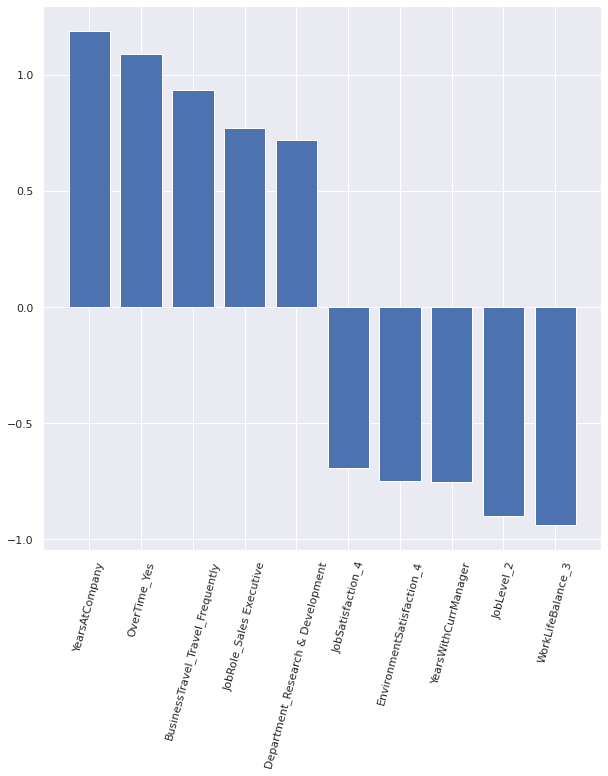

In [218]:
#visualize the most important features
fig = plt.figure(figsize = (10,10)) #go back to 14, 4 
plt.bar(x = pd.concat([feature_importance_LR.iloc[:5,0],feature_importance_LR.iloc[-5:,0]]), height = pd.concat([feature_importance_LR.iloc[:5,1],feature_importance_LR.iloc[-5:,1]]))
plt.xticks(rotation = 75)

In [219]:
#fit a new model based on most important feature -- no!! do feature engineering first

# xtrainover_df = pd.DataFrame(xtrainover)
# xtrainover_df.columns = X_train.columns

# small_xtrain = xtrainover_df[["OverTime_True", "JobRole_Sales Executive", "BusinessTravel_Travel_Frequently", "BusinessTravel_Travel_Rarely", "JobRole_Sales Representative", "JobRole_Laboratory Technician", "DistanceFromHome"]]
# small_xtest = X_test[["OverTime_True", "JobRole_Sales Executive", "BusinessTravel_Travel_Frequently", "BusinessTravel_Travel_Rarely", "JobRole_Sales Representative", "JobRole_Laboratory Technician", "DistanceFromHome"]]
# model.fit(small_xtrain, y_trainover)
# pred = model.predict(small_xtest)
# balanced_accuracy_score(y_test, pred)



# Feature Engineering - for better accruacy (SVD/PCA) 

Last Section of code to finish -- unless this is a seperate product

In [235]:
xtrainover_df = pd.DataFrame(xtrainover)
xtrainover_df.columns = X_train.columns

pca = PCA(n_components=5, svd_solver='full')
new_x = pca.fit(xtrainover_df)


In [236]:
new_x

PCA(copy=True, iterated_power='auto', n_components=5, random_state=None,
    svd_solver='full', tol=0.0, whiten=False)

#Exporting Table of Prediction Results

In [241]:
y_test = y_test.rename(columns={"Attrition_True": "Attrition"})

In [242]:
y_test

,Attrition,Predictions
569,0,0
110,0,1
1129,0,0
1136,1,1
208,0,0
...,...,...
366,1,0
259,1,1
759,0,1
391,0,0


In [239]:
y_test["Predictions"] = SMOTE_oversampling_predictions #Add the prediction array to the target test data 
# y_test.merge(X_test, left_index=True, right_index=True) #merge the actual target, predictions with the rest of the record for those employees
#merging with X_test only gives you the dummy encoded data and none of the droped data -- you dont get the employee number
#the order of the y_test, y predictions and x_test should all be the same -- which can be confirmed by the indices. 



In [245]:
#now merge the predictions with the original data by matching the indecies -- the reccords that were not in the test (dont have prediction will be filled in with an NA)
predictions = y_test.drop(['Attrition'], axis=1)
result = df.merge(predictions, how='left', left_index=True, right_index=True)
result.iloc[[110]]

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Predictions
110,51,False,Travel_Frequently,1456,Research & Development,1,4,Medical,1,145,1,Female,30,2,3,Healthcare Representative,1,Single,7484,25796,3,Y,No,20,4,3,80,0,23,1,2,13,12,12,8,1.0


In [246]:
#create a dataframe with just the employee numbers (ID), real attrition status and predictions
final_results = result[["EmployeeNumber","Attrition", "Predictions"]]

In [247]:
final_results['accuracy'] = final_results['Predictions'] #set accuracy column equal to prediction
#if prediction is null (ie was not in test), make accuracy null
#if prediction matched attrition, set accuracy to 1
#if prediction does not macth attrition, set accuracy to 0 
final_results['accuracy'] = np.where(final_results['accuracy'].isnull(), final_results['accuracy'], (final_results['Attrition']==final_results['Predictions']).astype(int))
final_results

,EmployeeNumber,Attrition,Predictions,accuracy
0,1,True,NaN,NaN
1,2,False,NaN,NaN
2,4,True,NaN,NaN
3,5,False,0.0,1.0
4,7,False,NaN,NaN
...,...,...,...,...
1465,2061,False,NaN,NaN
1466,2062,False,NaN,NaN
1467,2064,False,NaN,NaN
1468,2065,False,NaN,NaN


In [248]:
#pull out a dataframe of all the correctly predicted employees to export
employees_predicted_correctly = final_results[(final_results['accuracy'] == 1)] #find all the rows in the results df where the accuracy column equals 1 
employees_predicted_correctly.to_csv('employees_predicted_correctly.csv', index=False)
employees_predicted_correctly


,EmployeeNumber,Attrition,Predictions,accuracy
3,5,False,0.0,1.0
13,18,False,0.0,1.0
27,35,False,0.0,1.0
36,47,True,1.0,1.0
43,56,False,0.0,1.0
...,...,...,...,...
1445,2034,False,0.0,1.0
1451,2041,False,0.0,1.0
1454,2046,False,0.0,1.0
1459,2053,False,0.0,1.0


In [249]:
#pull out a dataframe of all the correctly predicted employees to export
employees_predicted_incorrectly = final_results[(final_results['accuracy'] == 0)]
employees_predicted_incorrectly.to_csv('employees_predicted_incorrectly.csv', index=False)
employees_predicted_incorrectly

,EmployeeNumber,Attrition,Predictions,accuracy
24,31,True,0.0,0.0
38,51,False,1.0,0.0
57,75,False,1.0,0.0
62,80,False,1.0,0.0
110,145,False,1.0,0.0
170,233,False,1.0,0.0
207,286,False,1.0,0.0
277,382,False,1.0,0.0
294,403,False,1.0,0.0
317,433,True,0.0,0.0
